## Detection on SIIM-COVID-19-DETECTION [YOLOv5s]

This goal of this notebook is solving the [SIIM-COVID19-DETECTION competition problem](https://www.kaggle.com/competitions/siim-covid19-detection/).

EDA has been performed in this [notebook](https://www.kaggle.com/code/martacoll/eda-siim-covid19-detection#1.-Data-description).

Dataset preprocessin has been done in this [notebook](https://www.kaggle.com/code/martacoll/data-preprocessing-siim-covid19-detection#DATA-PREPROCESSING-SIIM-COVID19-DETECTION).

YOLO framework will be used, which provides the following model architectures:

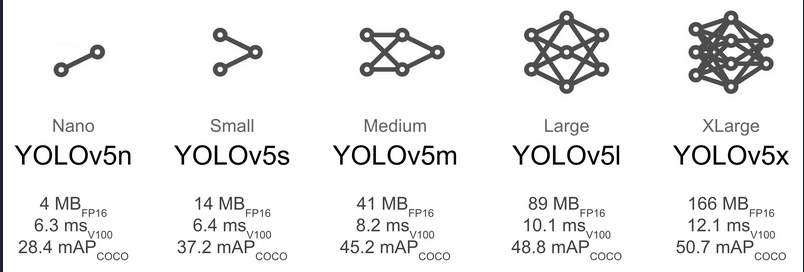

In order to track experiment runs and metrics, the tracking tools Weights and Biases and ClearML have been used. All experiment results can be explored in the following links, [W&B](https://wandb.ai/siimcovid19detection/kaggle-siim-covid19?workspace=user-mcollpol). ClearML only allows to share one experiment at a time, current best results: [ClearML](https://app.clear.ml/projects/5c79356a5c234ec6957855af71d7f496/experiments/72acd3e83b9a46e18db125371754b84e/output/execution).

## 0. Libraries and global variables:

In [1]:
# Download YOLOv5.
!git clone 'https://github.com/ultralytics/yolov5'  # clone repo
%cd yolov5
%pip install -qr 'requirements.txt'

# change directory
%cd ../

Cloning into 'yolov5'...
remote: Enumerating objects: 16117, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 16117 (delta 9), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16117/16117), 14.80 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (11033/11033), done.
/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.
/kaggle/working


In [2]:
!pip install wandb
!pip install clearml
!pip install seaborn==0.13.0
!pip install numpy==1.23.0

  Obtaining dependency information for clearml from https://files.pythonhosted.org/packages/0a/f1/ec897973d516c6cee3ef89bce9c8e058cc1d37ce770742321cd17ade2d35/clearml-1.13.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
  Obtaining dependency information for seaborn==0.13.0 from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is i

In [3]:
import os
import torch
import cv2
import warnings
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shutil

from kaggle_secrets import UserSecretsClient
from sklearn.model_selection import train_test_split
from shutil import copyfile
from glob import glob
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Log in to Weights & Biases
user_secrets = UserSecretsClient() 

personal_key_for_api = user_secrets.get_secret("wandb")

! wandb login $personal_key_for_api

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# Get keys for ClearML.
user_secrets = UserSecretsClient() 

access_key_for_clearml = user_secrets.get_secret("clearml_access")
secret_access_key_for_clearml = user_secrets.get_secret("clearml_secret_access")

In [6]:
# SET CLEARML ENVIRONMENT
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=$access_key_for_clearml
%env CLEARML_API_SECRET_KEY=$secret_access_key_for_clearml

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=KJXMS0NKF4B8XFUYXUM5
env: CLEARML_API_SECRET_KEY=L0TXJDzeRLKyB3j6BRekFJOawofwZyg9e5VMl3SDA4VkejdMIP


In [7]:
# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# GLOBAL VARIABLES
BASE_PATH = '../input/siim-covid19-detection-processed'
# Data Paths:
DATASET_NAME = 'resized256'
DATASET_PATH = os.path.join('/kaggle/working/datasets', DATASET_NAME)
IMAGES_TRAIN_PATH = os.path.join(DATASET_PATH,'images/train')
IMAGES_VAL_PATH = os.path.join(DATASET_PATH,'images/val')
IMAGES_TEST_PATH = os.path.join(DATASET_PATH,'images/test')
IMAGES_INFERENCE_PATH = os.path.join('..', BASE_PATH,'test')
LABELS_TRAIN_PATH = os.path.join(DATASET_PATH,'labels/train')
LABELS_VAL_PATH = os.path.join(DATASET_PATH,'labels/val')
LABELS_TEST_PATH = os.path.join(DATASET_PATH,'labels/test')

## 1. Loading Data

In [10]:
current_path = os.getcwd()
print("Current Path:", current_path)

Current Path: /kaggle/working


In [11]:
df = pd.read_csv(os.path.join(BASE_PATH,
                              'train_p.csv'))
df_boxes = pd.read_csv(os.path.join(BASE_PATH,
                                    'train_boxes_p.csv'))

In [12]:
df.head(3)

,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label,rows_resized,columns_resized
0,000c3a3f293f_image,ff0879eb20ed,1,0,0,0,train/000c3a3f293f.png,3,negative,256,256
1,0012ff7358bc_image,9d514ce429a7,0,1,0,0,train/0012ff7358bc.png,0,typical,256,256
2,000a312787f2_image,5776db0cec75,0,1,0,0,train/000a312787f2.png,0,typical,256,256


In [13]:
df_boxes.head()

,box_label,xmin,ymin,xmax,ymax,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label,rows,columns,rows_resized,columns_resized
0,none 1,0.0,0.0,1.0,1.0,000c3a3f293f_image,ff0879eb20ed,1,0,0,0,train/000c3a3f293f.png,3,negative,2320,2832,256,256
1,opacity 1,56.0,19.0,129.0,120.0,0012ff7358bc_image,9d514ce429a7,0,1,0,0,train/0012ff7358bc.png,0,typical,2544,3056,256,256
2,opacity 1,150.0,40.0,201.0,161.0,0012ff7358bc_image,9d514ce429a7,0,1,0,0,train/0012ff7358bc.png,0,typical,2544,3056,256,256
3,opacity 1,47.0,42.0,109.0,183.0,000a312787f2_image,5776db0cec75,0,1,0,0,train/000a312787f2.png,0,typical,3488,4256,256,256
4,opacity 1,135.0,43.0,200.0,172.0,000a312787f2_image,5776db0cec75,0,1,0,0,train/000a312787f2.png,0,typical,3488,4256,256,256


In [14]:
def plot_class_distribution(df, title):
    # Create a new DataFrame with counts aggregated by 'y_label'.
    agg_df = df.groupby('y_label').size().reset_index(name='count')

    # Create a bar plot.
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x='y_label',
                     y='count',
                     data=agg_df,
                     palette='viridis')

    # Add annotations with counts.
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

    # Set labels and title.
    plt.xlabel('Study Labels')
    plt.ylabel('Counts')
    plt.title(title)

    # Show the plot
    plt.show()

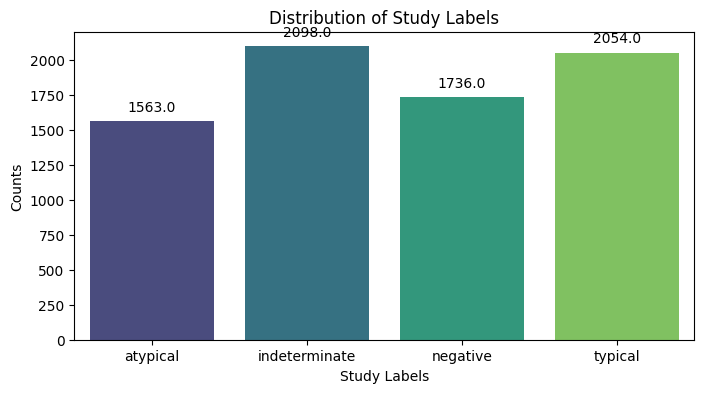

In [15]:
plot_class_distribution(df, 'Distribution of Study Labels')

## 2. Preparing data for YOLO

### 2.1 Negative for Pneumonia class

Negative for pneumonia class has no bounding boxes to be found. YOLOv5 predicts a 'Background' class for images where no bbox can be found. We want the model to asociate the Negative for pneumonia class with the 'background' class. For this reason these images will be included in the dataset, without any label asociated. By doing so, we will be helping reducing the False Positive scores as stated in the [official documentation](https://docs.ultralytics.com/yolov5/tutorials/tips_for_best_training_results/#dataset). Anyways, we will reduce this class to represent the 10% of the total amount of images in order to facilitate the models to learn to identify the ROIs, as suggested in the guide. 


In [16]:
#negative_class_ratio = 0.10

# Identify negative class rows.
negative_class_rows = df[df['Negative for Pneumonia'] == 1]

# Calculate the number of negative class rows to retain (10%).
num_negative_to_retain = 500

# Randomly sample the required number of negative class rows.
selected_negative_rows = negative_class_rows.sample(n=num_negative_to_retain,
                                                    random_state=42)

# Identify positive class rows.
positive_class_rows = df[df['Negative for Pneumonia'] != 1]

# Update dfs.
df = pd.concat([selected_negative_rows, positive_class_rows]).reset_index(drop=True)
df_boxes = df_boxes[df_boxes['id'].isin(df['id'])].reset_index(drop=True)

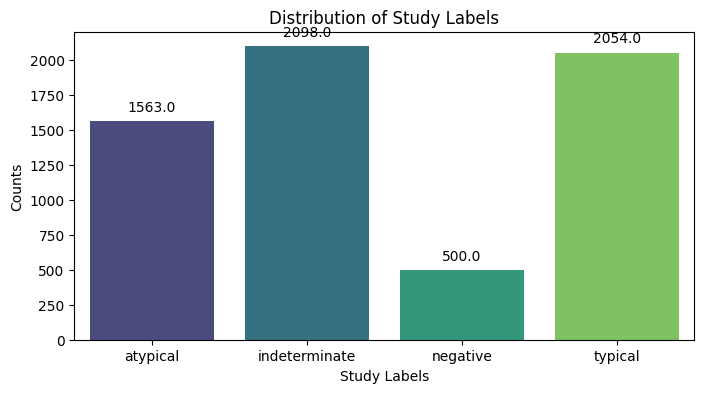

In [17]:
plot_class_distribution(df, 'Distribution of Study Labels')

### 2.2 Splitting Dataset

In [18]:
train_df, temp_df = train_test_split(df, test_size=0.2,
                                     random_state=42,
                                     stratify=df.int_label.values)
val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,
                                   random_state=42)

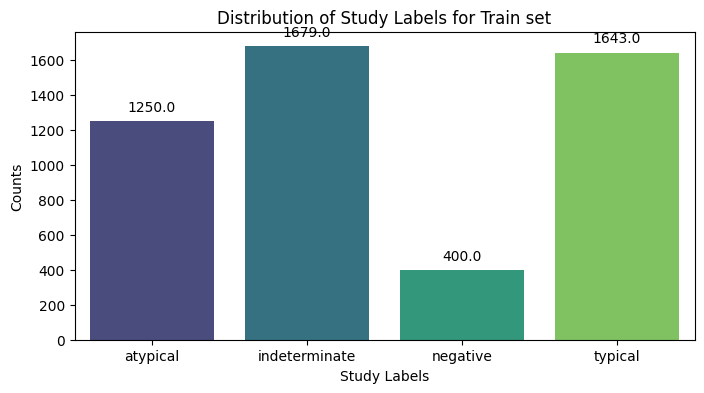

In [19]:
plot_class_distribution(train_df, 'Distribution of Study Labels for Train set')

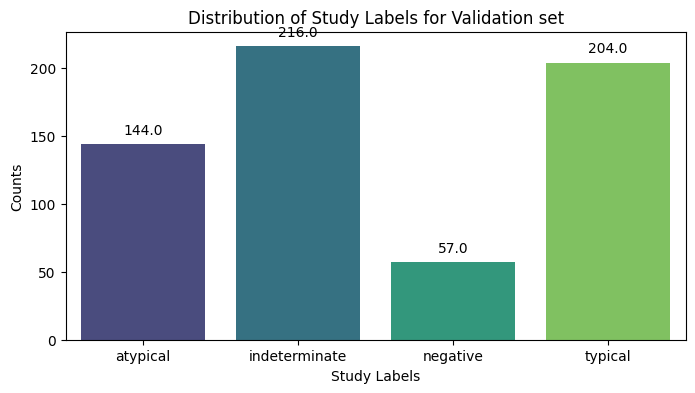

In [20]:
plot_class_distribution(val_df, 'Distribution of Study Labels for Validation set')

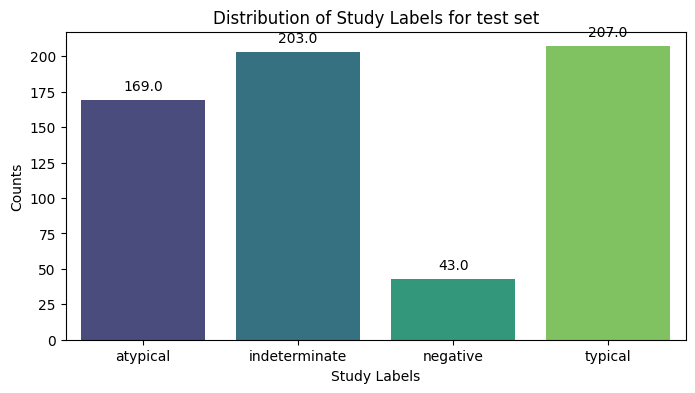

In [21]:
plot_class_distribution(test_df, 'Distribution of Study Labels for test set')

In [22]:
train_df.loc[:, 'split'] = 'train'
val_df.loc[:, 'split'] = 'val'
test_df.loc[:, 'split'] = 'test'

df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

In [23]:
df.head()

,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label,rows_resized,columns_resized,split
0,f263ce988492_image,23600e975e6f,0,1,0,0,train/f263ce988492.png,0,typical,256,256,train
1,3ce9e3acf26e_image,e13400ee01a1,0,0,1,0,train/3ce9e3acf26e.png,1,indeterminate,256,256,train
2,da_horizontal_flip_noise_injection_blur_f7f96b...,2990579c982c,0,0,1,0,train/da_horizontal_flip_noise_injection_blur_...,1,indeterminate,256,256,train
3,cb308b57472a_image,675662d319c7,0,0,1,0,train/cb308b57472a.png,1,indeterminate,256,256,train
4,4f6b571c20f0_image,0e76983343a5,1,0,0,0,train/4f6b571c20f0.png,3,negative,256,256,train


In [24]:
# Adding column split to df_boxes.
df_boxes = pd.merge(df_boxes, df[['id', 'split']], on='id', how='left')
df_boxes.head()

,box_label,xmin,ymin,xmax,ymax,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_path,int_label,y_label,rows,columns,rows_resized,columns_resized,split
0,opacity 1,56.0,19.0,129.0,120.0,0012ff7358bc_image,9d514ce429a7,0,1,0,0,train/0012ff7358bc.png,0,typical,2544,3056,256,256,train
1,opacity 1,150.0,40.0,201.0,161.0,0012ff7358bc_image,9d514ce429a7,0,1,0,0,train/0012ff7358bc.png,0,typical,2544,3056,256,256,train
2,opacity 1,47.0,42.0,109.0,183.0,000a312787f2_image,5776db0cec75,0,1,0,0,train/000a312787f2.png,0,typical,3488,4256,256,256,test
3,opacity 1,135.0,43.0,200.0,172.0,000a312787f2_image,5776db0cec75,0,1,0,0,train/000a312787f2.png,0,typical,3488,4256,256,256,test
4,opacity 1,155.0,51.0,187.0,91.0,0022227f5adf_image,84543edc24c2,0,0,1,0,train/0022227f5adf.png,1,indeterminate,2539,3050,256,256,train


### 2.3 Reorganize data

As stated in the YOLOv5 [official documentation](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#12-create-labels_1 ), data is expected in a specific organization structure.

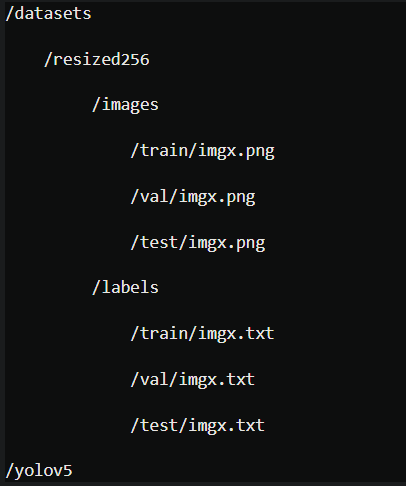

For creating lables txts, we should take into account: 

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).

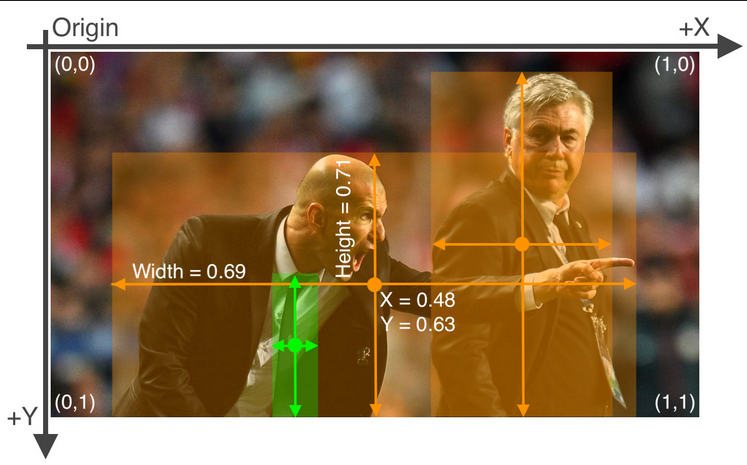

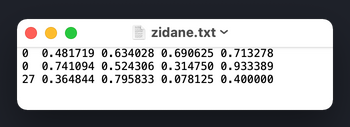

In [33]:
# Creating folder structure.
os.makedirs(IMAGES_TRAIN_PATH, exist_ok=True)
os.makedirs(LABELS_TRAIN_PATH, exist_ok=True)
os.makedirs(IMAGES_VAL_PATH, exist_ok=True)
os.makedirs(LABELS_VAL_PATH, exist_ok=True)
os.makedirs(IMAGES_TEST_PATH, exist_ok=True)
os.makedirs(LABELS_TEST_PATH, exist_ok=True)

In [26]:
def get_yolo_format_bbox(img_shape, bbox):
    """
    Function converts a bounding boxe in xmin, ymin, xmax, ymax 
    format to YOLO format.
    """

    w = bbox[2] - bbox[0] # xmax - xmin
    h = bbox[3] - bbox[1] # ymax - ymin
    xc = bbox[0] + float(w/2) # xmin + width/2
    yc = bbox[1] + float(h/2) # ymin + height/2
    
    return [xc/img_shape[0],
            yc/img_shape[1],
            w/img_shape[0],
            h/img_shape[1]] # x_center, y_center, width, height.

In [27]:
def write_label_txt(row, path):
    """
    Function writes label txt in path for a given df row.
    """
    with open(os.path.join(path, f'{row.id}.txt'), 'a') as file:
            bbox = [row.xmin, row.ymin, row.xmax, row.ymax]
            im_shape = [row.columns_resized, row.rows_resized]
            yolo_bbox = get_yolo_format_bbox(im_shape, bbox)
            # Write the new line.
            file.write(f'{row.int_label}\t{yolo_bbox[0]}\t{yolo_bbox[1]}' +
                       f'\t{yolo_bbox[2]}\t{yolo_bbox[3]}\n')

In [34]:
# Moving images to new folder structure.
for _, row in df_boxes.iterrows():
    if row.split == 'train':
        # Move image to proper folder.
        copyfile(os.path.join(BASE_PATH, row.image_path),
                 f'{IMAGES_TRAIN_PATH}/{row.id}.png')
        if row.y_label != 'negative':
            # Create or edit label txt for image.
            write_label_txt(row, LABELS_TRAIN_PATH)
    elif row.split == 'val':
        copyfile(os.path.join(BASE_PATH, row.image_path),
         f'{IMAGES_VAL_PATH}/{row.id}.png')
                # Create or edit label txt for image.
        if row.y_label != 'negative':
            write_label_txt(row, LABELS_VAL_PATH)
    else:
        copyfile(os.path.join(BASE_PATH, row.image_path),
         f'{IMAGES_TEST_PATH}/{row.id}.png')
                # Create or edit label txt for image.
        if row.y_label != 'negative':
            write_label_txt(row, LABELS_TEST_PATH)

### 2.4 Dataset Config file

In [35]:
config = {
    'path': DATASET_PATH,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',  
    'names': {
        0: 'typical',
        1: 'indeterminate',
        2: 'atypical',
    }
}

# Convert the dictionary to YAML and write it to a file
with open(f'/kaggle/working/yolov5/data/{DATASET_NAME}.yaml', 'w') as yaml_file:
    yaml.dump(config, yaml_file, default_flow_style=False)

print("YAML configuration created successfully.")

YAML configuration created successfully.


## 3. YOLO - Train

### 3.1 BEST HYPERPARAMETERS SEARCH YOLOV5m:

In [36]:
# HYPERPARAMS:
IMG_SIZE = int(df.iloc[0].rows_resized)
BATCH_SIZE = 32
EPOCHS = 10

In [37]:
%cd yolov5/

/kaggle/working/yolov5


In [38]:
# Best hyperparam exploration.
!python train.py --img {IMG_SIZE} \
                 --epochs {EPOCHS} \
                 --data {DATASET_NAME}.yaml \
                 --weights yolov5s.pt \
                 --project kaggle-siim-covid19 \
                 --cache \
                 --evolve 10

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: mcollpol (siimcovid19detection). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=resized256.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=10, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=kaggle-siim-covid19, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, a

In [39]:
hyp_evolve_path = '/kaggle/working/yolov5/kaggle-siim-covid19/exp/hyp_evolve.yaml'
with open(hyp_evolve_path, 'r') as file:
    yaml_data = yaml.safe_load(file)
    print("BEST HYPERPARAMETERS FOUND:")
    print(yaml.dump(yaml_data, default_flow_style=False))

BEST HYPERPARAMETERS FOUND:
anchor_t: 2.7115
anchors: 4.6614
box: 0.05483
cls: 0.50644
cls_pw: 1.3826
copy_paste: 0.0
degrees: 0.0
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.0
hsv_h: 0.01599
hsv_s: 0.86599
hsv_v: 0.25617
iou_t: 0.2
lr0: 0.01062
lrf: 0.01133
mixup: 0.0
momentum: 0.89648
mosaic: 0.97852
obj: 0.8006
obj_pw: 0.65433
perspective: 0.0
scale: 0.46363
shear: 0.0
translate: 0.10446
warmup_bias_lr: 0.10558
warmup_epochs: 1.8132
warmup_momentum: 0.86731
weight_decay: 0.00084



### 3.2 TRAIN WITH BEST PARAMS.

In [40]:
EPOCHS = 300
BATCH_SIZE = 128

In [41]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data {DATASET_NAME}.yaml \
                 --weights yolov5s.pt \
                 --project kaggle-siim-covid19 \
                 --hyp kaggle-siim-covid19/exp/hyp_evolve.yaml \
                 --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: mcollpol (siimcovid19detection). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=resized256.yaml, hyp=kaggle-siim-covid19/exp/hyp_evolve.yaml, epochs=300, batch_size=128, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=kaggle-siim-covid19, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requirement ['Pillow>=10.0.1']

### 3.3 TEST RESULTS:

In [42]:
!python val.py --img {IMG_SIZE} \
               --batch {BATCH_SIZE} \
               --task 'test' \
               --data {DATASET_NAME}.yaml \
               --weights kaggle-siim-covid19/exp2/weights/best.pt \
               --project kaggle-siim-covid19 \
               --conf 0.180 \
               --iou-thres 0.1 \
               --max-det 3

val: data=/kaggle/working/yolov5/data/resized256.yaml, weights=['kaggle-siim-covid19/exp2/weights/best.pt'], batch_size=128, imgsz=256, conf_thres=0.18, iou_thres=0.1, max_det=3, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=kaggle-siim-covid19, name=exp, exist_ok=False, half=False, dnn=False
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.8s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

WARNING ⚠️ confidence threshold 0.18 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7032600 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /kaggle/working/datasets/resized256/labels/test... 579 images, 43
test: 

#### Results:

In a confusion matrix for an object detection task, the "background-background" square is typically empty because it is not a meaningful or relevant comparison. The confusion matrix is designed to evaluate the model's performance in distinguishing between different classes, and the background class represents areas where no object is present.

Here's why the "background-background" square is empty:

Background Class (Negative Class):

The background class is usually treated as the negative class, representing areas where no object of interest is present. The goal of an object detection model is to identify and localize objects in an image, and the background class represents the absence of any such object.
True Negatives (TN):

The "background-background" square in the confusion matrix corresponds to true negatives (TN) for the background class. True negatives occur when the model correctly predicts the absence of an object in regions where there is indeed no object. Since the background class is meant to capture these true negatives, the diagonal element (TN) is the primary focus.
Other Squares:

Squares outside the diagonal in the background class row or column represent errors. False positives (FP) occur when the model incorrectly predicts the presence of an object in the background, and false negatives (FN) occur when the model fails to detect an object that is present in the background.

In summary, the "background-background" square being empty in the confusion matrix indicates that the model is correctly identifying regions without objects (true negatives) in the background class. The primary focus is on evaluating the model's performance in terms of errors (FP and FN) and correct predictions (TN) related to object classes rather than the absence of objects.


In [43]:
def plot_png(image_path):
    img = mpimg.imread(image_path)

    # Plot the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

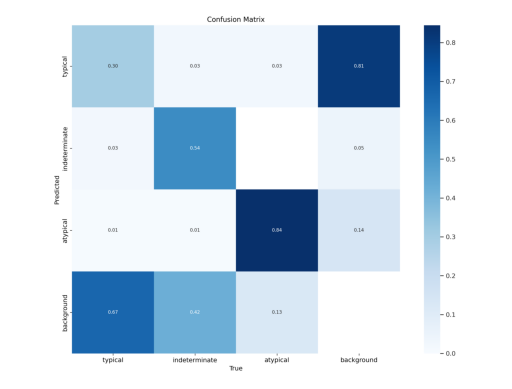

In [44]:
# Load the PNG image
image_path = '/kaggle/working/yolov5/kaggle-siim-covid19/exp3/confusion_matrix.png'
plot_png(image_path)

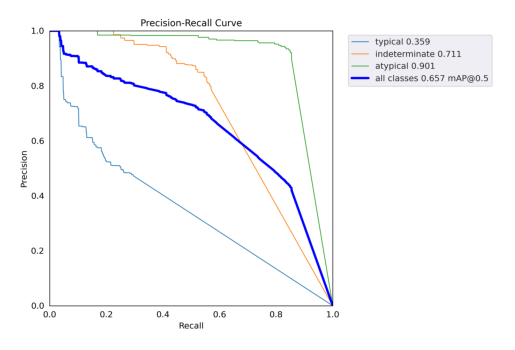

In [45]:
image_path = '/kaggle/working/yolov5/kaggle-siim-covid19/exp3/PR_curve.png'
plot_png(image_path)

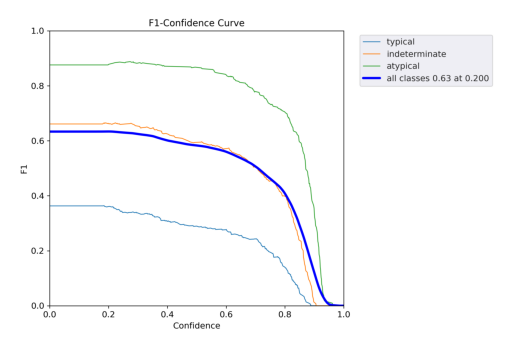

In [46]:
image_path = '/kaggle/working/yolov5/kaggle-siim-covid19/exp3/F1_curve.png'
plot_png(image_path)

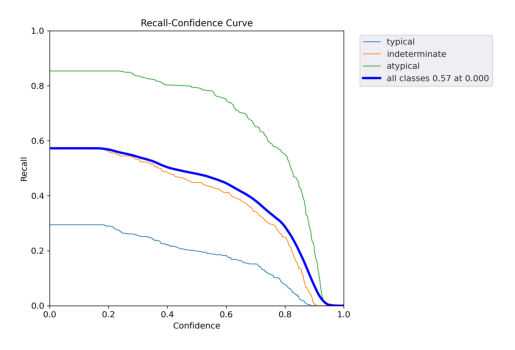

In [47]:
image_path = '/kaggle/working/yolov5/kaggle-siim-covid19/exp3/R_curve.png'
plot_png(image_path)

In [48]:
def del_dir(dir_path):
    try:
        shutil.rmtree(directory_to_delete)
        print(f"Directory '{directory_to_delete}' and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e}")

In [49]:
%cd ..

/kaggle/working


In [50]:
directory_to_delete = "/kaggle/working/yolov5"
del_dir(directory_to_delete)

Directory '/kaggle/working/yolov5' and its contents successfully removed.


In [51]:
directory_to_delete = "/kaggle/working/datasets"
del_dir(directory_to_delete)

Directory '/kaggle/working/datasets' and its contents successfully removed.


## 5. Results

Experiments have been stored and evaluated using Weights & Bias and ClearML to ensure reproducibility and a better analysis of results. All experiment results can be explored in the following links, [W&B](https://wandb.ai/siimcovid19detection/kaggle-siim-covid19/table?workspace=user-mcollpol). ClearML only allows to share one experiment at a time, current best results: [ClearML](https://app.clear.ml/projects/5c79356a5c234ec6957855af71d7f496/experiments/72acd3e83b9a46e18db125371754b84e/output/metrics/plots).

## References:

1. https://www.kaggle.com/code/ammarnassanalhajali/covid-19-detection-yolov5-3classes-training
2. https://docs.ultralytics.com/yolov5/
3. https://github.com/ultralytics/yolov5/wiki
4. https://github.com/ultralytics/yolov5/blob/master/val.py